# Imports

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


from xgboost import XGBRegressor

from embedder.regression import Embedder
from embedder.preprocessing import (categorize, pick_emb_dim, encode_categorical)
from embedder.assessment import visualize

# Subset 4

In [63]:
df_whole = pd.read_csv('/home/gean/Code/nns_performance_prediction/meta_datasets/nasbench101_4epochs_tabular.csv')
df_whole.head()

,module_adjacency,module_operations,trainable_parameters,halfway_training_time,halfway_train_accuracy,halfway_validation_accuracy,halfway_test_accuracy,final_training_time,final_train_accuracy,final_validation_accuracy,final_test_accuracy,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers
0,[[0 1 0 0 1 1 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",8555530,45.311667,0.102431,0.104100,0.103165,90.193001,0.338876,0.342481,0.340745,4,1,3,3,1
1,[[0 1 0 0 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu'...",5878154,31.692000,0.099025,0.101128,0.099359,64.218999,0.109876,0.113882,0.109041,5,1,3,1,0
2,[[0 1 0 0 0 1 0]\n [0 0 1 0 0 1 0]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",3729162,32.436334,0.099459,0.102497,0.099726,65.082334,0.277778,0.289697,0.283153,3,1,3,1,2
3,[[0 1 0 1 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu'...",3729162,32.122333,0.100995,0.099860,0.100227,64.062332,0.246595,0.248130,0.245726,3,1,3,1,2
4,[[0 1 0 0 0 0 0]\n [0 0 1 0 0 1 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'maxpool3x3', 'co...",3292298,29.019333,0.094284,0.094752,0.094384,58.018668,0.417401,0.422075,0.415832,3,1,3,1,2


In [64]:
df_whole['trainable_parameters'] = df_whole['trainable_parameters'].astype('float32')
df_whole.describe()

,trainable_parameters,halfway_training_time,halfway_train_accuracy,halfway_validation_accuracy,halfway_test_accuracy,final_training_time,final_train_accuracy,final_validation_accuracy,final_test_accuracy,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers
count,423624.0,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000,423624.000000
mean,8458520.0,44.737987,0.111793,0.112651,0.112208,89.476444,0.278090,0.278572,0.276598,3.227622,1.271269,2.705182,1.781755,1.613811
std,8558134.0,17.740547,0.030134,0.030637,0.030320,35.475207,0.144919,0.142872,0.141649,1.074315,0.697577,0.721375,0.984903,1.051364
min,227274.0,7.127667,0.058460,0.062133,0.058761,14.232334,0.053452,0.054253,0.052284,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2906692.0,31.805250,0.099058,0.099693,0.099893,63.626001,0.152444,0.154013,0.152945,3.000000,1.000000,3.000000,1.000000,1.000000
50%,5356682.0,38.955334,0.101629,0.102397,0.101629,77.871834,0.233407,0.236095,0.234709,3.000000,1.000000,3.000000,1.000000,2.000000
75%,10880650.0,55.766750,0.109976,0.110911,0.110343,111.557168,0.388822,0.389256,0.386619,4.000000,1.000000,3.000000,3.000000,2.000000
max,49979272.0,119.663002,0.479434,0.480836,0.471454,239.169001,0.724893,0.708433,0.701088,5.000000,3.000000,3.000000,3.000000,5.000000


In [65]:
y_np = df_whole['final_validation_accuracy'].to_numpy()

In [66]:
print("Mean: ", np.mean(y_np))
print("Median: ", np.median(y_np))
print("Q1: ", np.quantile(y_np, 0.25))
print("Q3: ", np.quantile(y_np, 0.75))

Mean:  0.27857229665694105
Median:  0.2360945
Q1:  0.154013
Q3:  0.389256


In [67]:
df_aux = df_whole.drop(['halfway_training_time', 'halfway_train_accuracy', 'halfway_validation_accuracy', 'halfway_test_accuracy', 
                       'final_training_time', 'final_train_accuracy', 'module_adjacency', 'module_operations'], 
                       axis = 1)
df_aux = df_aux[['conv_num_layers', 'conv_kernel_min', 'conv_kernel_max', 'conv_kernel_mode', 
                 'maxpool_num_layers', 'trainable_parameters', 'final_validation_accuracy', 'final_test_accuracy']]
df_aux

,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers,trainable_parameters,final_validation_accuracy,final_test_accuracy
0,4,1,3,3,1,8555530.0,0.342481,0.340745
1,5,1,3,1,0,5878154.0,0.113882,0.109041
2,3,1,3,1,2,3729162.0,0.289697,0.283153
3,3,1,3,1,2,3729162.0,0.248130,0.245726
4,3,1,3,1,2,3292298.0,0.422075,0.415832
...,...,...,...,...,...,...,...,...
423619,5,1,3,3,0,40848008.0,0.144064,0.144865
423620,3,1,3,1,2,4166026.0,0.163929,0.167234
423621,4,1,1,1,1,2362378.0,0.268830,0.261552
423622,2,1,1,1,3,4705162.0,0.148337,0.150274


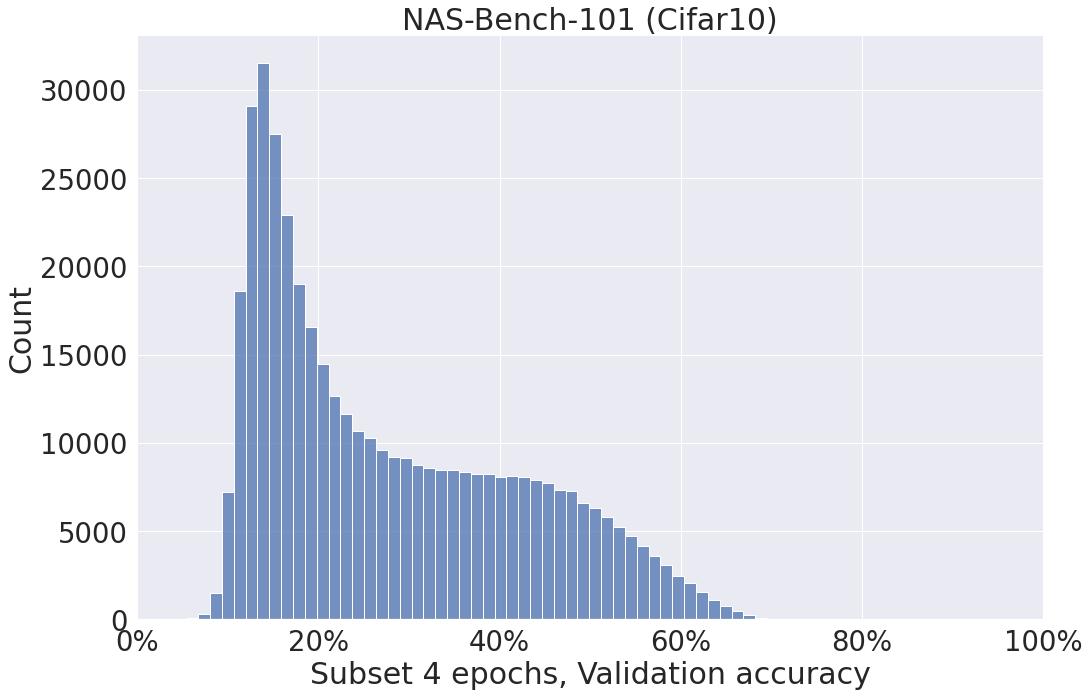

In [68]:
sns.set(font_scale=2.5)

ax = sns.displot(df_whole['final_validation_accuracy'], bins=50, height=10, aspect=15.7/10.27).set(xlim=(0, 1.0))
ax.set(xlabel='Subset 4 epochs, Validation accuracy')
plt.title("NAS-Bench-101 (Cifar10)")
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_4epochs_val_acc_dist.pdf", 
           bbox_inches='tight')

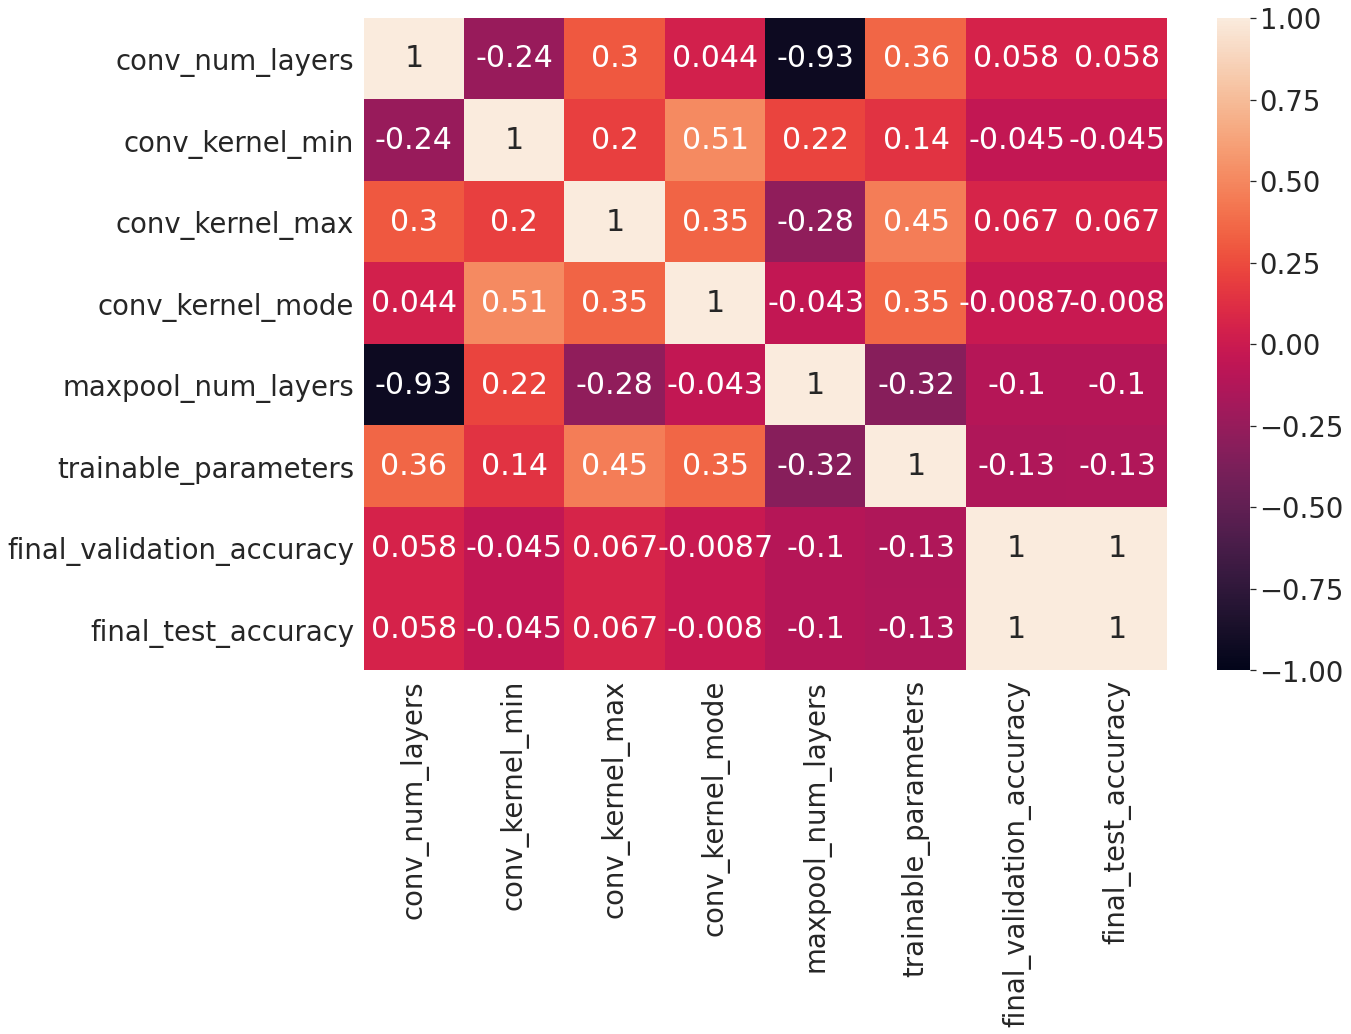

In [69]:
plt.figure(figsize=(18, 12))
sns.heatmap(df_aux.corr(method='spearman'), vmin=-1, vmax=1, annot=True)

plt.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_4epochs_features_spearman_corr.pdf", 
            transparent=True, bbox_inches='tight')  

# Test Acc

In [72]:
y_np = df_whole['final_test_accuracy'].to_numpy()
print("Mean: ", np.mean(y_np))
print("Median: ", np.median(y_np))
print("Q1: ", np.quantile(y_np, 0.25))
print("Q3: ", np.quantile(y_np, 0.75))

Mean:  0.2765981318173664
Median:  0.234709
Q1:  0.152945
Q3:  0.386619


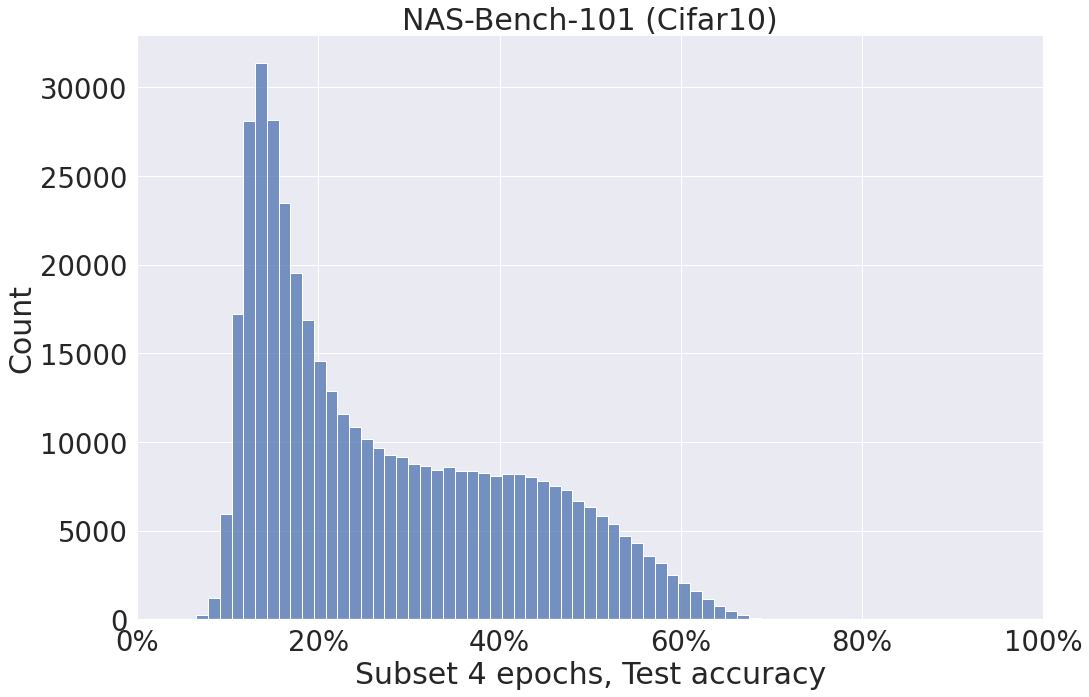

In [73]:
sns.set(font_scale=2.5)

ax = sns.displot(df_whole['final_test_accuracy'], bins=50, height=10, aspect=15.7/10.27).set(xlim=(0, 1.0))
ax.set(xlabel='Subset 4 epochs, Test accuracy')
plt.title("NAS-Bench-101 (Cifar10)")
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_4epochs_test_acc_dist.pdf", 
           bbox_inches='tight')

# Subset 12

In [74]:
df_whole = pd.read_csv('/home/gean/Code/nns_performance_prediction/meta_datasets/nasbench101_12epochs_tabular.csv')
df_whole.head()

,module_adjacency,module_operations,trainable_parameters,halfway_training_time,halfway_train_accuracy,halfway_validation_accuracy,halfway_test_accuracy,final_training_time,final_train_accuracy,final_validation_accuracy,final_test_accuracy,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers
0,[[0 1 0 0 1 1 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",8555530,108.143333,0.128839,0.129808,0.129808,217.339335,0.498564,0.486579,0.487179,4,1,3,3,1
1,[[0 1 0 0 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu'...",5878154,75.839999,0.202524,0.204627,0.202858,151.717667,0.412059,0.414296,0.410490,5,1,3,1,0
2,[[0 1 0 0 0 1 0]\n [0 0 1 0 0 1 0]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",3729162,80.861333,0.270666,0.269030,0.268763,161.638662,0.652577,0.627337,0.628673,3,1,3,1,2
3,[[0 1 0 1 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu'...",3729162,79.201335,0.193276,0.192308,0.191840,158.331340,0.515425,0.497563,0.499733,3,1,3,1,2
4,[[0 1 0 0 0 0 0]\n [0 0 1 0 0 1 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'maxpool3x3', 'co...",3292298,74.767670,0.322650,0.319344,0.319478,149.386668,0.585804,0.572082,0.568510,3,1,3,1,2


In [75]:
y_np = df_whole['final_validation_accuracy'].to_numpy()

In [76]:
print("Mean: ", np.mean(y_np))
print("Median: ", np.median(y_np))
print("Q1: ", np.quantile(y_np, 0.25))
print("Q3: ", np.quantile(y_np, 0.75))

Mean:  0.5270524587204692
Median:  0.542902
Q1:  0.367688
Q3:  0.70406


In [77]:
df_aux = df_whole.drop(['halfway_training_time', 'halfway_train_accuracy', 'halfway_validation_accuracy', 'halfway_test_accuracy', 
                       'final_training_time', 'final_train_accuracy', 'module_adjacency', 'module_operations'], 
                       axis = 1)
df_aux = df_aux[['conv_num_layers', 'conv_kernel_min', 'conv_kernel_max', 'conv_kernel_mode', 
                 'maxpool_num_layers', 'trainable_parameters', 'final_validation_accuracy', 'final_test_accuracy']]
df_aux

,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers,trainable_parameters,final_validation_accuracy,final_test_accuracy
0,4,1,3,3,1,8555530,0.486579,0.487179
1,5,1,3,1,0,5878154,0.414296,0.410490
2,3,1,3,1,2,3729162,0.627337,0.628673
3,3,1,3,1,2,3729162,0.497563,0.499733
4,3,1,3,1,2,3292298,0.572082,0.568510
...,...,...,...,...,...,...,...,...
423619,5,1,3,3,0,40848010,0.300080,0.297309
423620,3,1,3,1,2,4166026,0.416533,0.422175
423621,4,1,1,1,1,2362378,0.395366,0.396802
423622,2,1,1,1,3,4705162,0.411425,0.409989


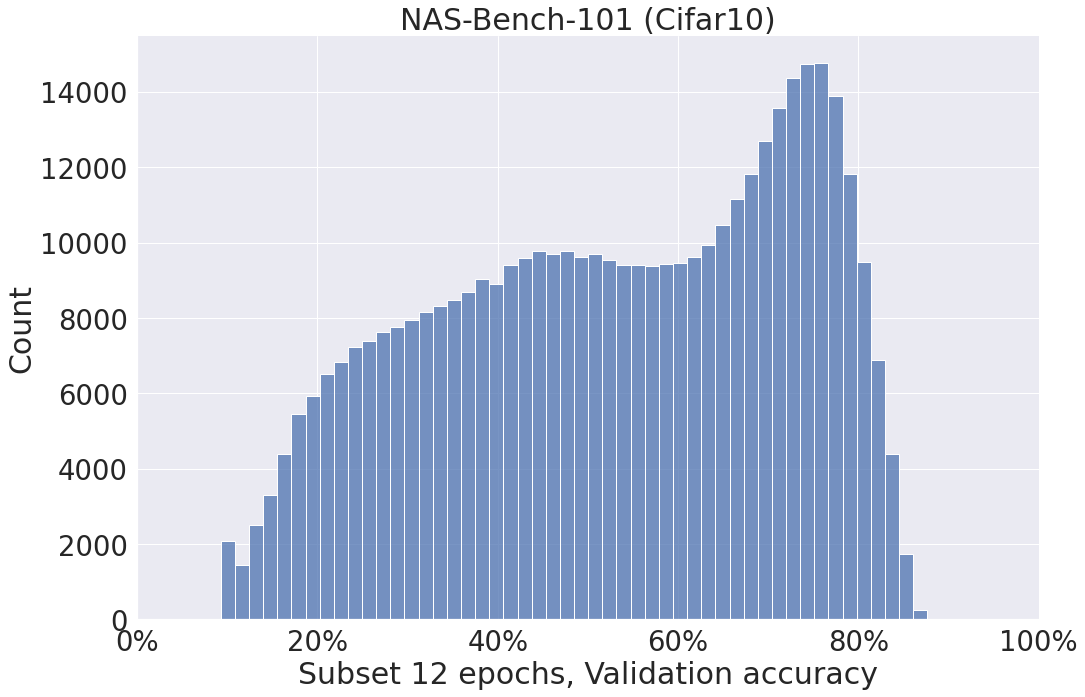

In [78]:
sns.set(font_scale=2.5)

ax = sns.displot(df_whole['final_validation_accuracy'], bins=50, height=10, aspect=15.7/10.27).set(xlim=(0, 1.0))
ax.set(xlabel='Subset 12 epochs, Validation accuracy')
plt.title("NAS-Bench-101 (Cifar10)")
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_12epochs_val_acc_dist.pdf", 
           bbox_inches='tight')

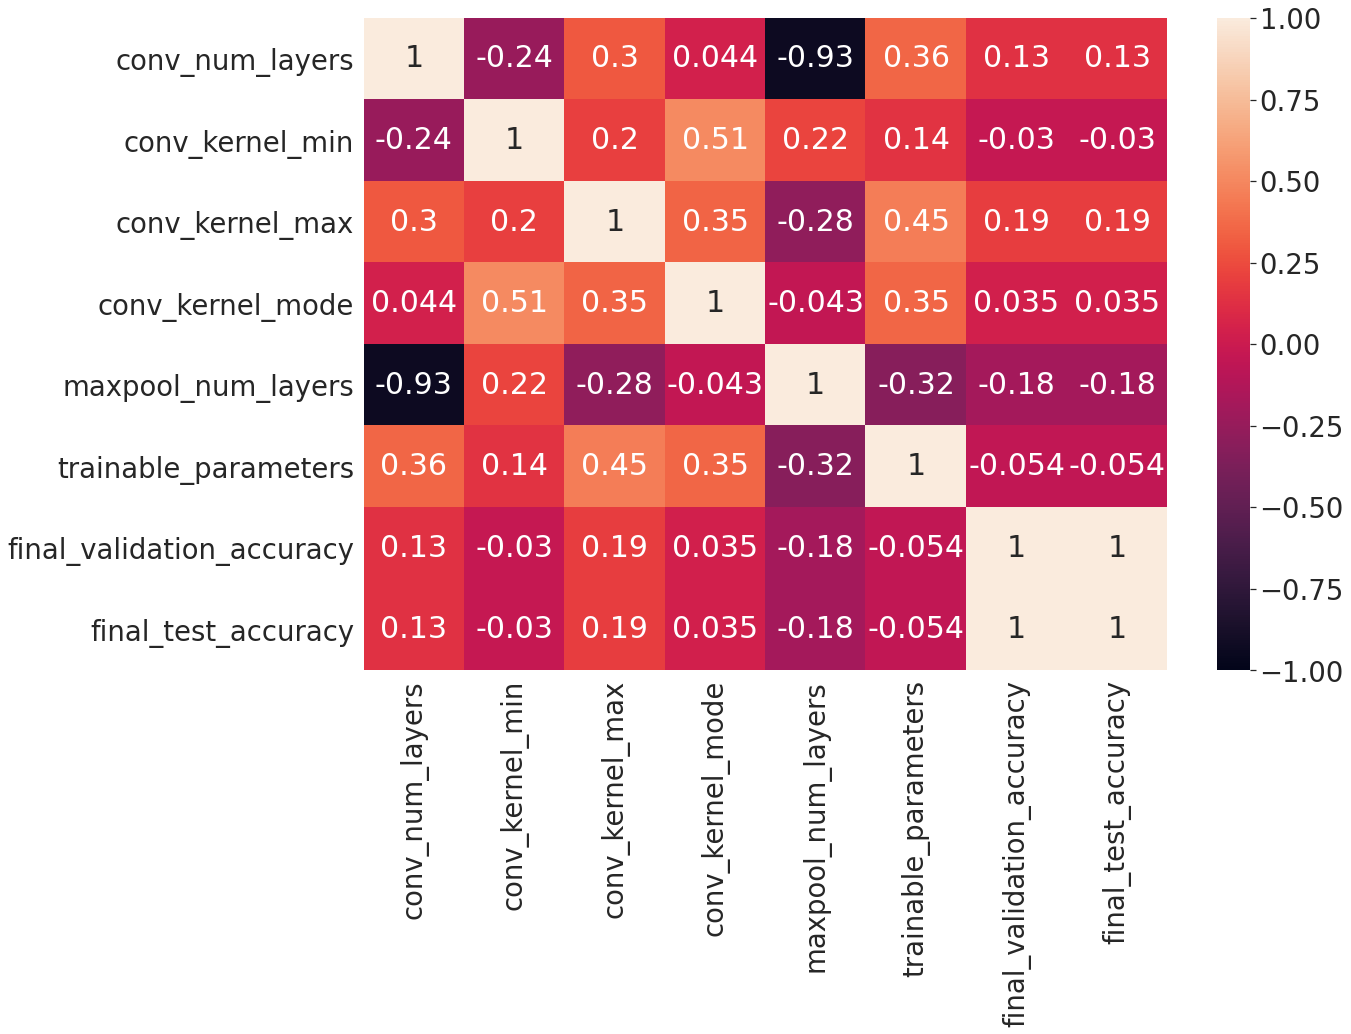

In [79]:
plt.figure(figsize=(18, 12))
sns.heatmap(df_aux.corr(method='spearman'), vmin=-1, vmax=1, annot=True)

plt.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_12epochs_features_spearman_corr.pdf", 
            transparent=True, bbox_inches='tight')  

# Test Acc

In [80]:
y_np = df_whole['final_test_accuracy'].to_numpy()
print("Mean: ", np.mean(y_np))
print("Median: ", np.median(y_np))
print("Q1: ", np.quantile(y_np, 0.25))
print("Q3: ", np.quantile(y_np, 0.75))

Mean:  0.5242327517373898
Median:  0.5417
Q1:  0.36859000000000003
Q3:  0.697349


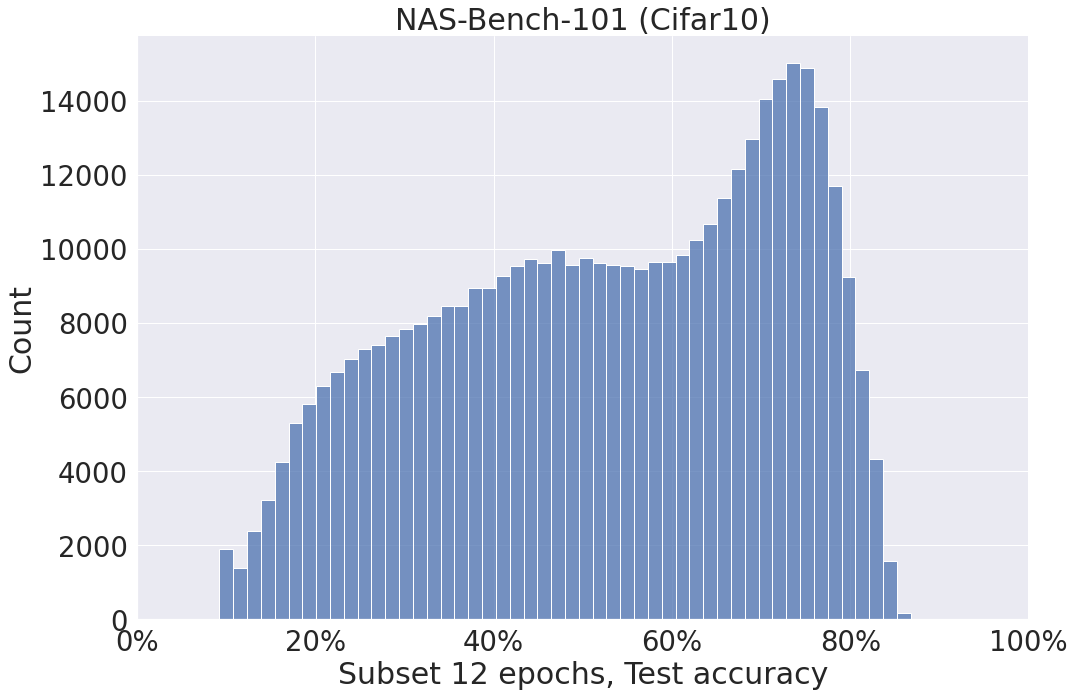

In [81]:
sns.set(font_scale=2.5)

ax = sns.displot(df_whole['final_test_accuracy'], bins=50, height=10, aspect=15.7/10.27).set(xlim=(0, 1.0))
ax.set(xlabel='Subset 12 epochs, Test accuracy')
plt.title("NAS-Bench-101 (Cifar10)")
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_12epochs_test_acc_dist.pdf", 
           bbox_inches='tight')

# Subset 36

In [82]:
df_whole = pd.read_csv('/home/gean/Code/nns_performance_prediction/meta_datasets/nasbench101_36epochs_tabular.csv')
df_whole.head()

,module_adjacency,module_operations,trainable_parameters,halfway_training_time,halfway_train_accuracy,halfway_validation_accuracy,halfway_test_accuracy,final_training_time,final_train_accuracy,final_validation_accuracy,final_test_accuracy,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers
0,[[0 1 0 0 1 1 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",8555530,307.087006,0.466446,0.446915,0.448551,614.015361,0.984241,0.898037,0.886919,4,1,3,3,1
1,[[0 1 0 0 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu'...",5878154,210.115000,0.187934,0.187433,0.186064,420.408000,0.855736,0.808193,0.801149,5,1,3,1,0
2,[[0 1 0 0 0 1 0]\n [0 0 1 0 0 1 0]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",3729162,230.788330,0.270767,0.258948,0.260817,461.787333,0.983707,0.890057,0.883614,3,1,3,1,2
3,[[0 1 0 1 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu'...",3729162,225.415665,0.243623,0.235243,0.238648,450.954987,0.925714,0.848491,0.842415,3,1,3,1,2
4,[[0 1 0 0 0 0 0]\n [0 0 1 0 0 1 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'maxpool3x3', 'co...",3292298,215.120336,0.237513,0.228098,0.230669,429.919332,0.931290,0.851062,0.843483,3,1,3,1,2


In [83]:
y_np = df_whole['final_validation_accuracy'].to_numpy()

In [84]:
print("Mean: ", np.mean(y_np))
print("Median: ", np.median(y_np))
print("Q1: ", np.quantile(y_np, 0.25))
print("Q3: ", np.quantile(y_np, 0.75))

Mean:  0.8419901537944028
Median:  0.8653850000000001
Q1:  0.8257549999999999
Q3:  0.893864


In [85]:
df_aux = df_whole.drop(['halfway_training_time', 'halfway_train_accuracy', 'halfway_validation_accuracy', 'halfway_test_accuracy', 
                       'final_training_time', 'final_train_accuracy', 'module_adjacency', 'module_operations'], 
                       axis = 1)
df_aux = df_aux[['conv_num_layers', 'conv_kernel_min', 'conv_kernel_max', 'conv_kernel_mode', 
                 'maxpool_num_layers', 'trainable_parameters', 'final_validation_accuracy', 'final_test_accuracy']]
df_aux

,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers,trainable_parameters,final_validation_accuracy,final_test_accuracy
0,4,1,3,3,1,8555530,0.898037,0.886919
1,5,1,3,1,0,5878154,0.808193,0.801149
2,3,1,3,1,2,3729162,0.890057,0.883614
3,3,1,3,1,2,3729162,0.848491,0.842415
4,3,1,3,1,2,3292298,0.851062,0.843483
...,...,...,...,...,...,...,...,...
423619,5,1,3,3,0,40848010,0.836238,0.825654
423620,3,1,3,1,2,4166026,0.854367,0.844585
423621,4,1,1,1,1,2362378,0.799746,0.799079
423622,2,1,1,1,3,4705162,0.819511,0.814904


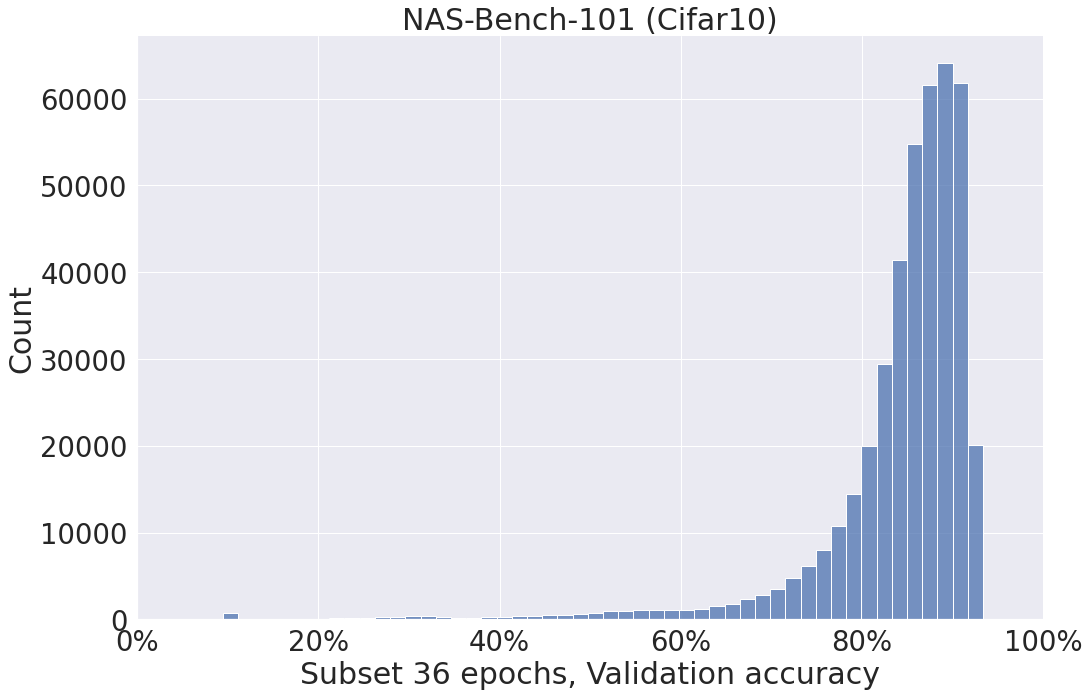

In [86]:
sns.set(font_scale=2.5)

ax = sns.displot(df_whole['final_validation_accuracy'], bins=50, height=10, aspect=15.7/10.27).set(xlim=(0, 1.0))
ax.set(xlabel='Subset 36 epochs, Validation accuracy')
plt.title("NAS-Bench-101 (Cifar10)")
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_36epochs_val_acc_dist.pdf", 
           bbox_inches='tight')

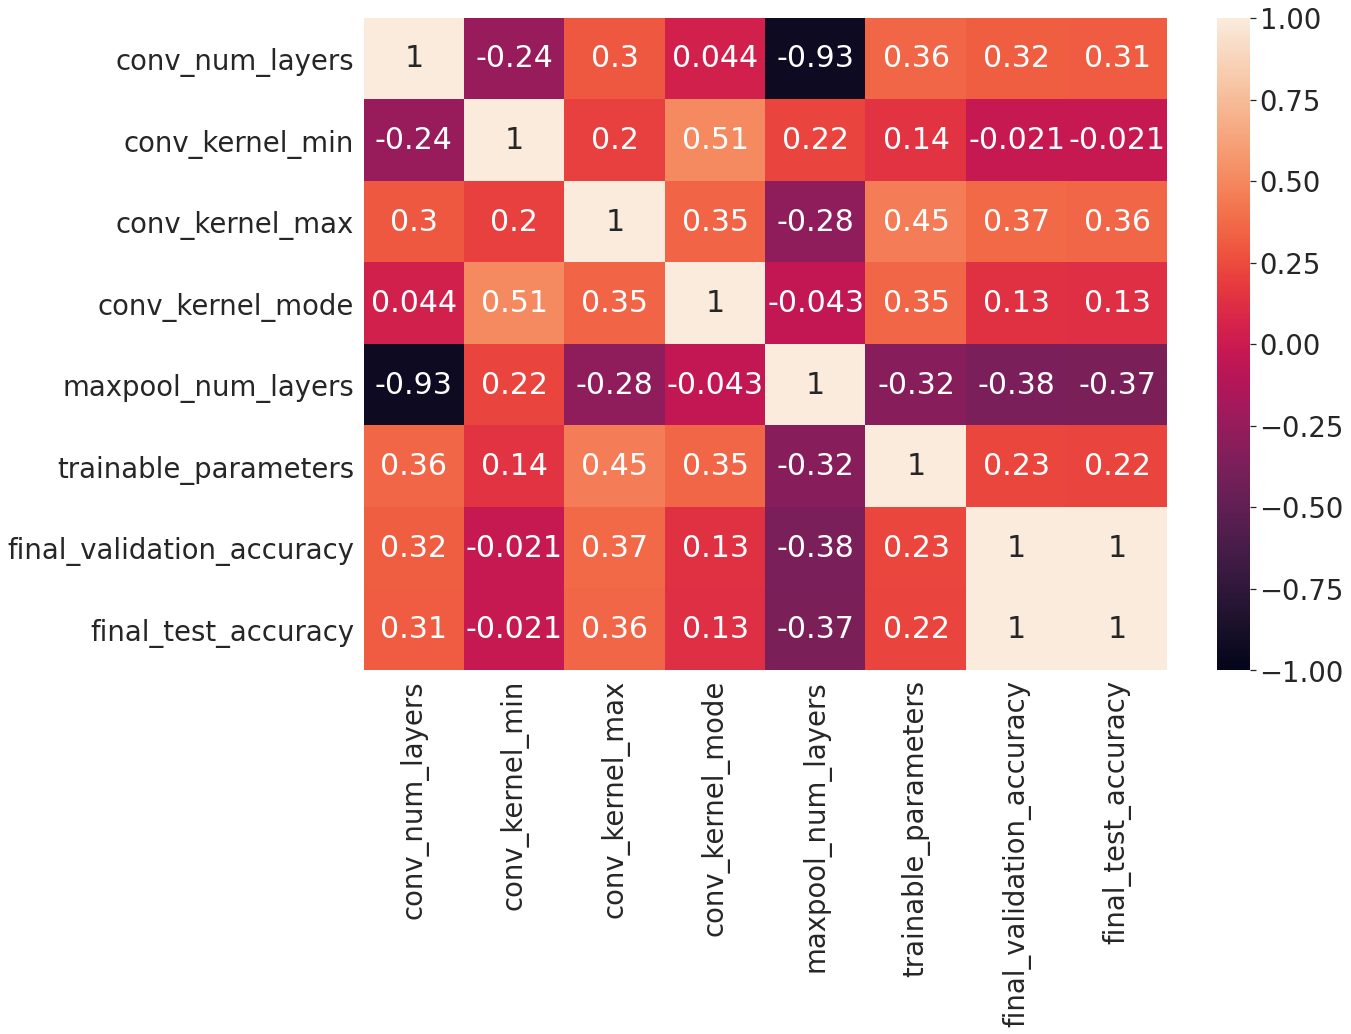

In [87]:
plt.figure(figsize=(18, 12))
sns.heatmap(df_aux.corr(method='spearman'), vmin=-1, vmax=1, annot=True)

plt.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_36epochs_features_spearman_corr.pdf", 
            transparent=True, bbox_inches='tight')  

# Test Acc

In [88]:
y_np = df_whole['final_test_accuracy'].to_numpy()
print("Mean: ", np.mean(y_np))
print("Median: ", np.median(y_np))
print("Q1: ", np.quantile(y_np, 0.25))
print("Q3: ", np.quantile(y_np, 0.75))

Mean:  0.835046799746946
Median:  0.8586739999999999
Q1:  0.818209
Q3:  0.8869520000000001


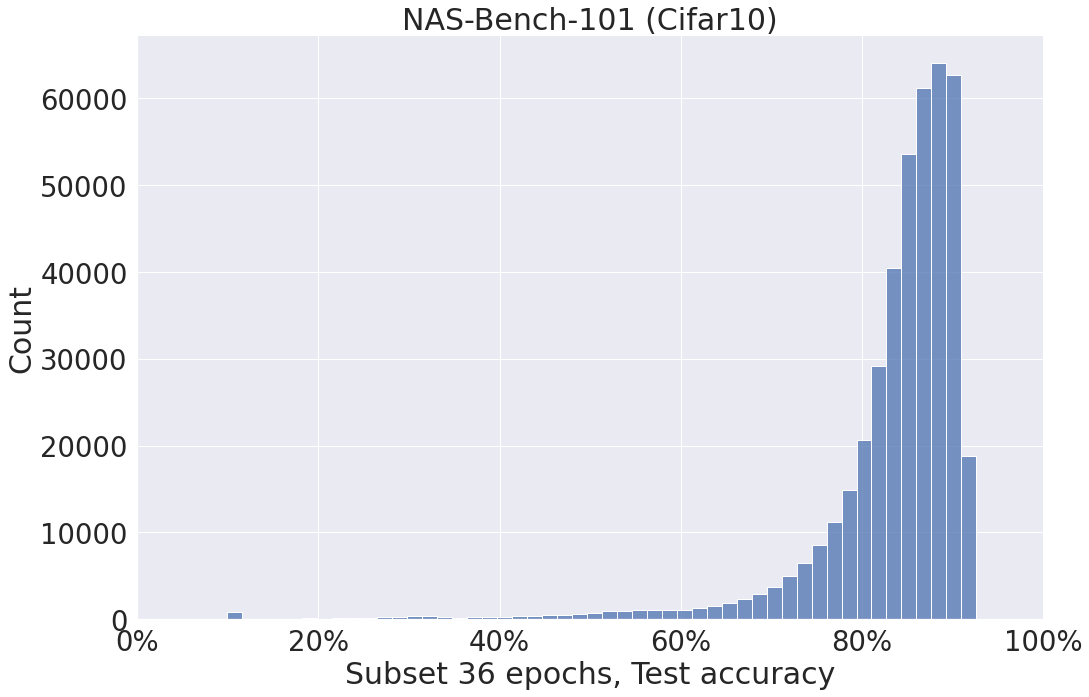

In [89]:
sns.set(font_scale=2.5)

ax = sns.displot(df_whole['final_test_accuracy'], bins=50, height=10, aspect=15.7/10.27).set(xlim=(0, 1.0))
ax.set(xlabel='Subset 36 epochs, Test accuracy')
plt.title("NAS-Bench-101 (Cifar10)")
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_36epochs_test_acc_dist.pdf", 
           bbox_inches='tight')

# Subset 108

In [90]:
df_whole = pd.read_csv('/home/gean/Code/nns_performance_prediction/meta_datasets/nasbench101_108epochs_tabular.csv')
df_whole.head()

,module_adjacency,module_operations,trainable_parameters,halfway_training_time,halfway_train_accuracy,halfway_validation_accuracy,halfway_test_accuracy,final_training_time,final_train_accuracy,final_validation_accuracy,final_test_accuracy,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers
0,[[0 1 0 0 1 1 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",8555530,883.532003,0.857105,0.806123,0.800113,1768.784953,1.000000,0.926416,0.920606,4,1,3,3,1
1,[[0 1 0 0 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu'...",5878154,602.919006,0.573351,0.549479,0.552217,1206.150024,0.998130,0.894631,0.886452,5,1,3,1,0
2,[[0 1 0 0 0 1 0]\n [0 0 1 0 0 1 0]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",3729162,671.023987,0.818977,0.765959,0.764290,1343.049967,1.000000,0.927350,0.922643,3,1,3,1,2
3,[[0 1 0 1 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu'...",3729162,650.621989,0.721554,0.682626,0.678619,1302.710978,0.999933,0.909756,0.905148,3,1,3,1,2
4,[[0 1 0 0 0 0 0]\n [0 0 1 0 0 1 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'maxpool3x3', 'co...",3292298,625.477661,0.626603,0.605202,0.595052,1251.861003,0.999866,0.897169,0.894231,3,1,3,1,2


In [91]:
y_np = df_whole['final_validation_accuracy'].to_numpy()

In [92]:
print("Mean: ", np.mean(y_np))
print("Median: ", np.median(y_np))
print("Q1: ", np.quantile(y_np, 0.25))
print("Q3: ", np.quantile(y_np, 0.75))

Mean:  0.902433875795517
Median:  0.912326
Q1:  0.8959
Q3:  0.9248799999999999


In [93]:
df_aux = df_whole.drop(['halfway_training_time', 'halfway_train_accuracy', 'halfway_validation_accuracy', 'halfway_test_accuracy', 
                       'final_training_time', 'final_train_accuracy', 'module_adjacency', 'module_operations'], 
                       axis = 1)
df_aux = df_aux[['conv_num_layers', 'conv_kernel_min', 'conv_kernel_max', 'conv_kernel_mode', 
                 'maxpool_num_layers', 'trainable_parameters', 'final_validation_accuracy', 'final_test_accuracy']]
df_aux

,conv_num_layers,conv_kernel_min,conv_kernel_max,conv_kernel_mode,maxpool_num_layers,trainable_parameters,final_validation_accuracy,final_test_accuracy
0,4,1,3,3,1,8555530,0.926416,0.920606
1,5,1,3,1,0,5878154,0.894631,0.886452
2,3,1,3,1,2,3729162,0.927350,0.922643
3,3,1,3,1,2,3729162,0.909756,0.905148
4,3,1,3,1,2,3292298,0.897169,0.894231
...,...,...,...,...,...,...,...,...
423619,5,1,3,3,0,40848010,0.910557,0.905716
423620,3,1,3,1,2,4166026,0.905115,0.897937
423621,4,1,1,1,1,2362378,0.868222,0.866086
423622,2,1,1,1,3,4705162,0.884482,0.881010


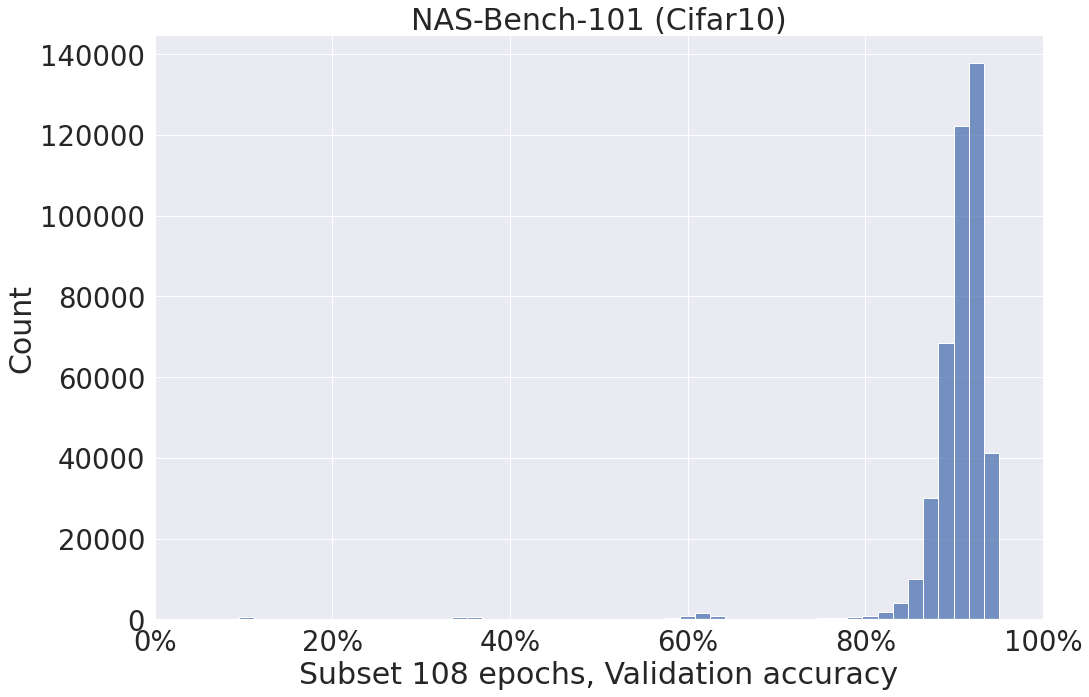

In [94]:
sns.set(font_scale=2.5)

ax = sns.displot(df_whole['final_validation_accuracy'], bins=50, height=10, aspect=15.7/10.27).set(xlim=(0, 1.0))
ax.set(xlabel='Subset 108 epochs, Validation accuracy')
plt.title("NAS-Bench-101 (Cifar10)")
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_108epochs_val_acc_dist.pdf", 
           bbox_inches='tight')

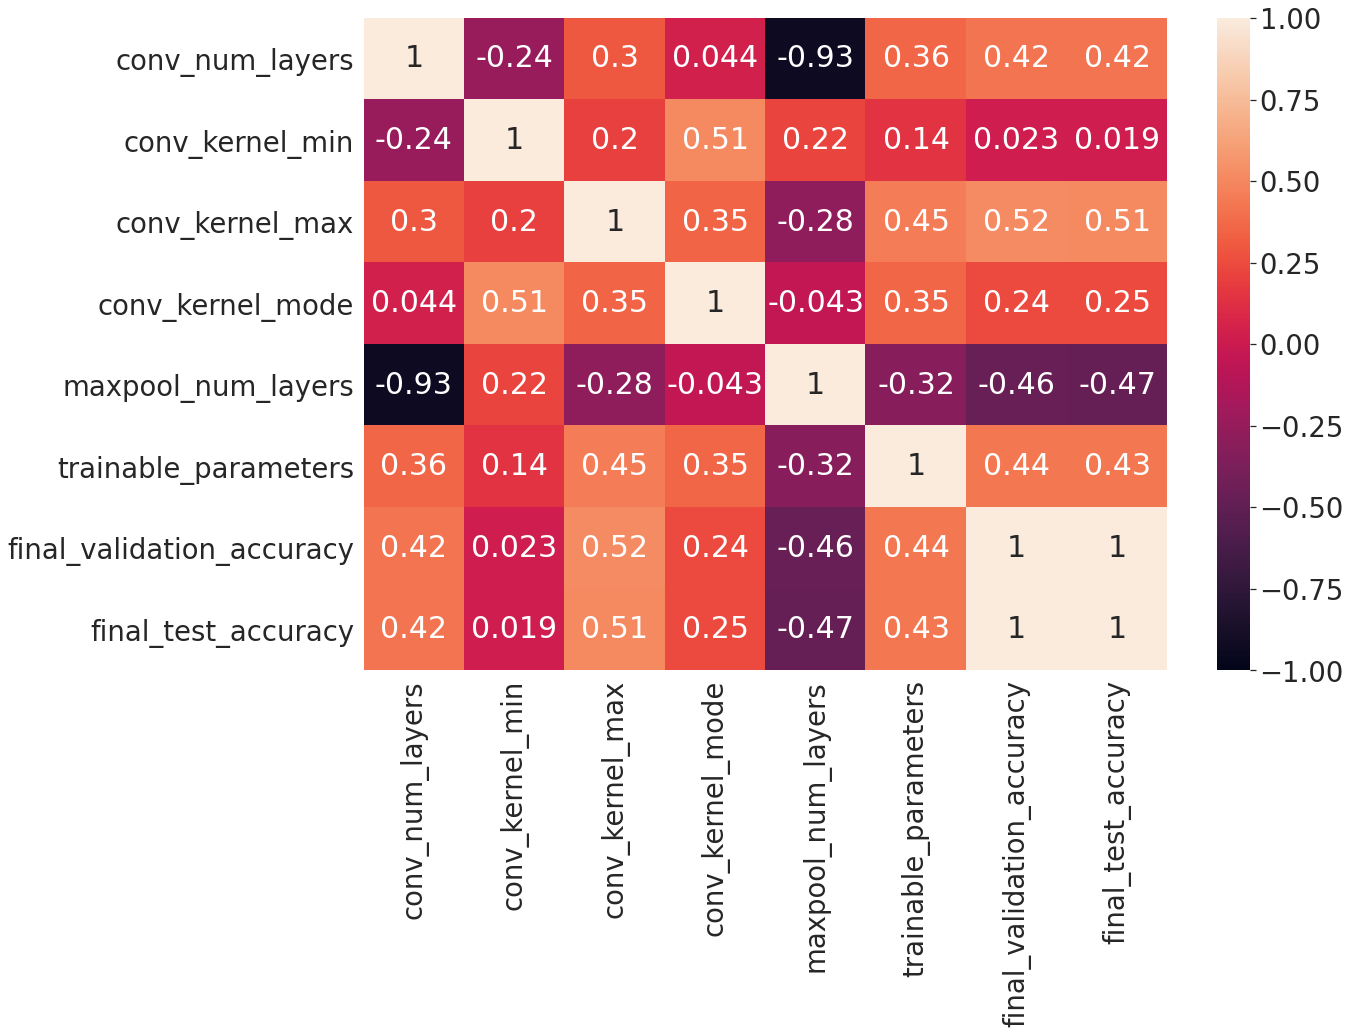

In [95]:
plt.figure(figsize=(18, 12))
sns.heatmap(df_aux.corr(method='spearman'), vmin=-1, vmax=1, annot=True)

plt.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_108epochs_features_spearman_corr.pdf", 
            transparent=True, bbox_inches='tight')  

# Test Acc

In [96]:
y_np = df_whole['final_test_accuracy'].to_numpy()
print("Mean: ", np.mean(y_np))
print("Median: ", np.median(y_np))
print("Q1: ", np.quantile(y_np, 0.25))
print("Q3: ", np.quantile(y_np, 0.75))

Mean:  0.896798463599796
Median:  0.906384
Q1:  0.890091
Q3:  0.9192040000000001


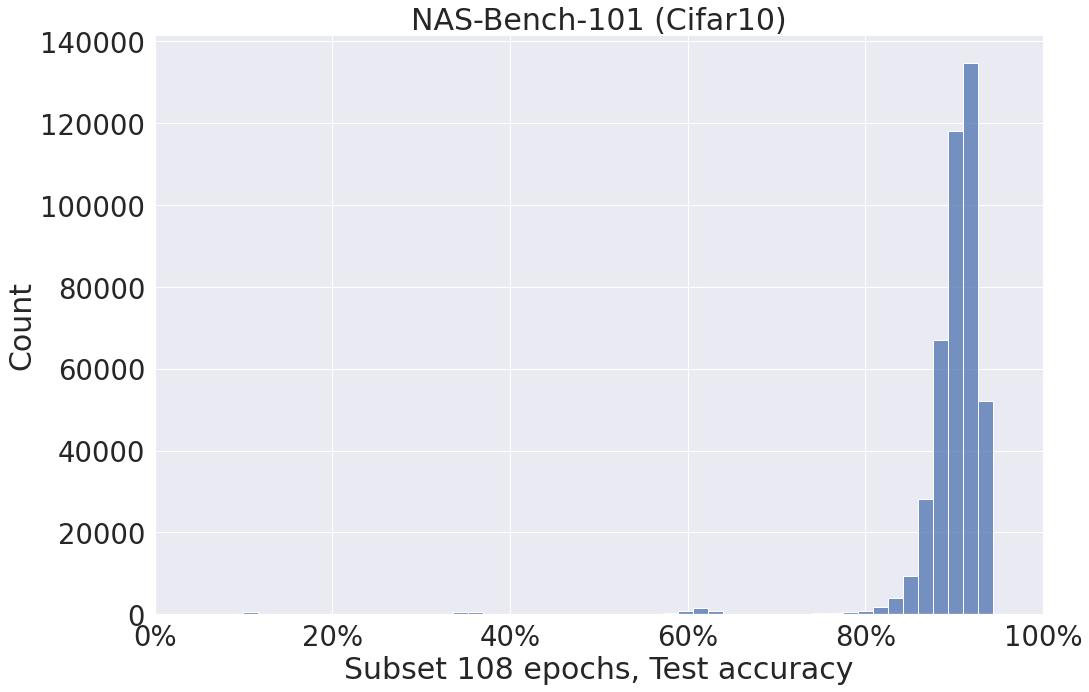

In [97]:
sns.set(font_scale=2.5)

ax = sns.displot(df_whole['final_test_accuracy'], bins=50, height=10, aspect=15.7/10.27).set(xlim=(0, 1.0))
ax.set(xlabel='Subset 108 epochs, Test accuracy')
plt.title("NAS-Bench-101 (Cifar10)")
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.savefig("/home/gean/Code/nns_performance_prediction/results/nasbench101_cifar10_108epochs_test_acc_dist.pdf", 
           bbox_inches='tight')